# Step 1. Import packages and helper functions

In [1]:
import numpy as np
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from Bio.Seq import Seq
import pandas as pd
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import plotly.graph_objects as go
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px

In [2]:
primer = "CAGGAAGTAGCTAAGGAGTACAAATGAATTATG"
refSeq = "ATAGAAGCACCAGATGTTAAACCTTGGCTATTCTTGATTAAACCCTATGAAGGGGAAAGCCTGAGCCACTTTCTTGGCAGGTTCAGACGTGCCAACCATTTATCCGCAAGTGGATTGGGTACTTTGGCAGGAATTGGTGCTATAGTGGCACGTTGGGAAAGATTTCATTTTAATCCTCGCCCTAGTCAGCAAGAATTGGAAGCGATCGCATCTGTAGTAGAAGTGGATGCTCAAAGGTTAGCCCAGATGTTACCGCCTGCTGGAGTGGGAATGCAGCATGAGCCAATTCGCTTGTGTGGGGCTTGTTATGCCGAGTCGCCTTGTCACCGAATTGAATGGCAGTACAAGTCGGTGTGGAAGTGCGATCGCCATCAACTCAAGATTTTAGCAAAGTGTCCAAACTGTCAAGCACCTTTTAAAATGCCTGCGCTGTGGGAGGATGGGTGCTGTCACAGATGTAGGATGCCGTTTGCAGAAATGGCAAAGCTACAGAAGGTT"
AA_refSeq=str(Seq(refSeq).translate())
refSeq_len=len(refSeq)

In [3]:
#RBS not found in TniQ sequence
refSeq.rfind('ATTAAAGAGGAGAAA'),refSeq.rfind('TCACACAGGAAACC'), refSeq.rfind('TCACACAGGAAAG')

(-1, -1, -1)

In [4]:
def translate_seq(seq):
    """
    Translates a DNA sequence into its corresponding amino acid sequence.
    
    Parameters:
    seq (str): A string representing the DNA sequence.
    
    Returns:
    str: The translated amino acid sequence as a string.
    """
    dna_seq = Seq(seq)
    return str(dna_seq.translate())

def get_mutation_info(aa_seq,nt_seq,ref_nt,ref_aa):
    """
    Identifies amino acid (AA) and nucleotide (NT) mutations between the given sequences and their reference sequences.
    
    Parameters:
    aa_seq (str): The amino acid sequence to compare.
    nt_seq (str): The nucleotide sequence to compare.
    ref_nt (str): The reference nucleotide sequence.
    ref_aa (str): The reference amino acid sequence.
    
    Returns:
    tuple: A tuple containing:
        - Number of amino acid mutations (int)
        - Number of nucleotide mutations (int)
        - String representation of amino acid mutations (str)
        - String representation of nucleotide mutations (str)
    """
    diff_aa = [i for i in range(len(aa_seq)) if ref_aa[i] != aa_seq[i]]
    diff_nt = [i for i in range(len(nt_seq)) if ref_nt[i] != nt_seq[i]]
    mut_aa='+'.join([ref_aa[i]+str(i+2)+aa_seq[i] for i in diff_aa])
    mut_nt='+'.join([ref_nt[i]+str(i+2)+nt_seq[i] for i in diff_nt])
    return len(diff_aa),len(diff_nt),mut_aa,mut_nt 

def process_seq2(seqs,primer,refSeq_len,ref_nt,ref_aa):
    """
    Processes a list of sequences to find the offset using a primer, translates the sequence if its size matches the reference,
    and identifies mutations.

    Parameters:
    seqs (list of str): List of DNA sequences to be processed.
    primer (str): The primer sequence used to find the offset.
    refSeq_len (int): The length of the reference sequence.
    ref_nt (str): The reference nucleotide sequence.
    ref_aa (str): The reference amino acid sequence.

    Returns:
    list: A list of processed sequence information. Each element is a list containing:
        - Translated amino acid sequence (str) or 0 if size does not match reference
        - Nucleotide sequence without offset (str) or 0 if size does not match reference
        - Number of amino acid mutations (int)
        - Number of nucleotide mutations (int)
        - String representation of amino acid mutations (str)
        - String representation of nucleotide mutations (str)
    """
    rseqs=[]
    for seq in seqs:
        offset=seq.rfind(primer)+len(primer)
        wo_offset_seq=seq[offset:offset+refSeq_len]
        if len(wo_offset_seq)==refSeq_len:
            aa_seq=translate_seq(wo_offset_seq)
            n_aa_mut, n_nt_mut, mut_aa, mut_nt=get_mutation_info(aa_seq,wo_offset_seq,ref_nt,ref_aa)
            rseqs.append([aa_seq,wo_offset_seq,n_aa_mut, n_nt_mut, mut_aa, mut_nt])
        else:
            rseqs.append([0,0])
    return rseqs

def generate_df(file, primer, refSeq_len, refSeq, AA_refSeq, nc=20,nt_counts=10,aa_counts=0,batch_size=100000):
    """
    Generates a DataFrame from a FASTQ file containing DNA sequences, processes the sequences to find mutations, and filters the results.

    Parameters:
    file (str): Path to the FASTQ file.
    primer (str): The primer sequence used to find the offset.
    refSeq_len (int): The length of the reference sequence.
    refSeq (str): The reference nucleotide sequence.
    AA_refSeq (str): The reference amino acid sequence.
    nc (int): Number of CPU cores to use for parallel processing.
    nt_counts (int): Minimum number of reads for nucleotide sequences to be included in the final DataFrame.
    aa_counts (int): Minimum number of reads for amino acid sequences to be included in the final DataFrame.
    batch_size (int): Number of sequences to process in each batch.

    Returns:
    DataFrame: A DataFrame containing information about the processed sequences and their mutations.
    """
    print('Processing ',file)
    #Load file
    fastq_gen = FastqGeneralIterator(open(file))
    seqs=[i[1] for i in fastq_gen]
    #Translate and filter nucleotides sequences
    print('Translating sequences')
    out=Parallel(n_jobs=nc)(delayed(process_seq2)(seqs[i:i+batch_size], primer, refSeq_len, refSeq, AA_refSeq) for i in tqdm(range(0,len(seqs),batch_size)))
    results=[]
    for i in range(len(out)):
        for j in out[i]:
            results.append(j)
    good_seqs=np.array([r[0]!=0 for r in results])
    print('Number of senquences with the right length: ',np.sum(good_seqs),'out of ',len(seqs))
    del seqs
    results=[results[i] for i in range(len(results)) if good_seqs[i]==True]
    results=np.array(results,dtype=object)
    results[results=='']='WT'
    #Merge information into data frame
    d = {'AA_mut_list': results[:,4], 'NT_mut_list': results[:,5],
        'AA_mut_#': results[:,2], 'NT_mut_#': results[:,3], 
        'AA_seq': results[:,0], 'NT_seq': results[:,1]
        }
    df = pd.DataFrame(data=d)
    #Remove duplicates while keeping reads
    counts=df['AA_mut_list'].value_counts()
    df['reads_AA']=df['AA_mut_list'].map(counts)
    counts=df['NT_mut_list'].value_counts()
    df['reads_NT']=df['NT_mut_list'].map(counts)
    df = df.drop_duplicates(subset=['AA_mut_list', 'NT_mut_list'])
    #Compute frequency of each variant
    df['freq_AA']=df['reads_AA']/np.sum(df['reads_NT'])
    df['freq_NT']=df['reads_NT']/np.sum(df['reads_NT'])
    #Filter for low reads
    df=df[(df['reads_AA']>aa_counts)*(df['reads_NT']>nt_counts)]
    #Filter X in AA sequences
    df=df[np.array([not 'X' in i for i in df['AA_mut_list']])]
    print(len(df),'variants with more than',nt_counts,'reads and with no X in AA sequence')
    return df

def create_df(data):
    """
    Creates a DataFrame from a numpy array with mutation and sequence data.

    Parameters:
    data (numpy.ndarray): A 2D numpy array where each row contains:
        - AA_mut_list (str): List of amino acid mutations.
        - NT_mut_list (str): List of nucleotide mutations.
        - AA_mut_# (int): Number of amino acid mutations.
        - NT_mut_# (int): Number of nucleotide mutations.
        - AA_seq (str): Amino acid sequence.
        - NT_seq (str): Nucleotide sequence.
        - reads_AA (int): Read count for amino acid mutations.
        - reads_NT (int): Read count for nucleotide mutations.
        - freq_AA (float): Frequency of amino acid mutations.
        - freq_NT (float): Frequency of nucleotide mutations.

    Returns:
    DataFrame: A pandas DataFrame containing the provided data with appropriate column names.
    """
    df = {
            'AA_mut_list': pd.Series(data[:,0]),
            'NT_mut_list': pd.Series(data[:,1]),
            'AA_mut_#': pd.Series(data[:,2]),       
            'NT_mut_#': pd.Series(data[:,3]),
            'AA_seq': pd.Series(data[:,4]),
            'NT_seq': pd.Series(data[:,5]),
            'reads_AA': pd.Series(data[:,6]),
            'reads_NT': pd.Series(data[:,7]),
            'freq_AA': pd.Series(data[:,8]),
            'freq_NT': pd.Series(data[:,9])
    }
    return pd.DataFrame(df)


# Step 2a. Process Fastq data 
### Skip this step if processed data file (./data_kan_ara_filter.npy) is present

In [ ]:
the=0
print('Counts thershole',the)
df_input_R1=generate_df('./Input/R1_input.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)
df_input_R2=generate_df('./Input/R2_input.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)
df_Kan_R1=generate_df('./Kan/R1_Kan.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)
df_Kan_R2=generate_df('./Kan/R2_Kan.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)
df_Ara_R1=generate_df('./Ara/R1_Ara.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)
df_Ara_R2=generate_df('./Ara/R2_Ara.fastq', primer, refSeq_len, refSeq, AA_refSeq,nc=20,nt_counts=the)

# Save processed data
with open('./data_kan_ara.npy', 'wb') as f:
    np.save(f, df_input_R1) 
    np.save(f, df_input_R2)
    np.save(f, df_Kan_R1)
    np.save(f, df_Kan_R2)
    np.save(f, df_Ara_R1)
    np.save(f, df_Ara_R2)

# Step 2b. Load processed data saved in data_kan_ara.npy 

In [ ]:
# Load processed data
with open('./data_kan_ara.npy', 'rb') as f:
    df_input_R1=create_df(np.load(f,allow_pickle=True))
    df_input_R2=create_df(np.load(f,allow_pickle=True))
    df_Kan_R1=create_df(np.load(f,allow_pickle=True))
    df_Kan_R2=create_df(np.load(f,allow_pickle=True))
    df_Ara_R1=create_df(np.load(f,allow_pickle=True))
    df_Ara_R2=create_df(np.load(f,allow_pickle=True))

In [6]:
def merged_df_nt(d1,d2,suffixes,the):
    """
    Merges two DataFrames on nucleotide and amino acid mutation information, filters based on read counts, and calculates enrichment and standard error.

    Parameters:
    d1 (DataFrame): First DataFrame containing mutation and sequence data.
    d2 (DataFrame): Second DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    the (int): Threshold for filtering sequences based on read counts.

    Returns:
    DataFrame: A merged DataFrame with calculated enrichment and standard error.
    """
    d1=d1[d1['reads_NT']>the]
    df12=pd.merge(d1, d2, on=['NT_mut_list','NT_mut_#','AA_mut_list','AA_mut_#','NT_seq','AA_seq'],how='left',suffixes=suffixes)
    df12=df12.replace(np.nan,0)
    wt_sel=d2[d2['NT_mut_list']=='WT']['reads_NT'].values[0]+0.5
    wt_inp=d1[d1['NT_mut_list']=='WT']['reads_NT'].values[0]+0.5
    counts_sel=np.array(df12['reads_NT'+suffixes[1]].values,dtype=float)+0.5
    counts_inp=np.array(df12['reads_NT'+suffixes[0]].values,dtype=float)+0.5
    enrich=np.log2(counts_sel/wt_sel) - np.log2(counts_inp/wt_inp)
    df12['enrich'+suffixes[1]]=enrich
    s=1/wt_sel + 1/wt_inp + 1/(df12['reads_NT'+suffixes[1]]+0.5).values + 1/(df12['reads_NT'+suffixes[0]]+0.5).values
    df12['stderr'+suffixes[1]]=np.sqrt(np.array(s,dtype=float))
    return df12

def merged_df_replicates(d1,d2,suffixes):
    """
    Merges two DataFrames on nucleotide and amino acid mutation information.

    Parameters:
    d1 (DataFrame): First DataFrame containing mutation and sequence data.
    d2 (DataFrame): Second DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    DataFrame: A merged DataFrame containing columns from both input DataFrames.
    """
    df12=pd.merge(d1, d2, on=['NT_mut_list','NT_mut_#','AA_mut_list','AA_mut_#','NT_seq','AA_seq'],suffixes=suffixes)
    return df12

def mut_in_context(df,suffixes,mutation,style):
    """
    Plots the enrichment score of a specific mutation in the context of wild-type synonymous mutations.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    mutation (str): The specific mutation to highlight in the plot.
    style (str): The style of the plot, specifying which column to use for the x-axis.
    """
    mut=mutation
    fig=plt.figure(figsize=(3,2.5))
    ax=fig.add_subplot(111)
    ax.set_title(mut+' '+style+' in\ncontext of WT syn mut')
    kernel = stats.gaussian_kde(df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]])

    sub_df=df[df['AA_mut_list']==mut]
    ax.errorbar(sub_df[style].values[0],[0.4],xerr=sub_df['stderr'].values[0],capsize=5,color='k',barsabove=False)
    ax.scatter(sub_df['enrich'+suffixes[0]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    ax.scatter(sub_df['enrich'+suffixes[1]],np.zeros(len(sub_df))+0.4,c='k',s=5)
    scatter=ax.scatter(sub_df[style].values[0],[0.4],c='white',edgecolor='k')
    x=np.linspace(-5,5,50)
    ax.plot(x,kernel(x)/4,color='k')
    ax.plot(x,-kernel(x)/4,color='k')
    ax.fill_between(x,kernel(x)/4,-kernel(x)/4,edgecolor='gray',facecolor='gray')

    ax.set_xlabel('Score')
    ax.set_yticks([])
    ax.set_ylim([-0.3,0.8])
    return fig

def score_n_error(df,mut,suffixes):
    """
    Calculates the score and error for a specific mutation using weighted averages and iterative refinement.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]
    replicates=2*len(sub_df)
    scores=np.concatenate([sub_df['enrich'+suffixes[0]].values,sub_df['enrich'+suffixes[1]].values])
    errors=np.concatenate([sub_df['stderr'+suffixes[0]].values,sub_df['stderr'+suffixes[1]].values])
    error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
    tmp_error=error
    for _ in range(50):
        num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
        den=np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_beta=num/den
        num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
        den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
        tmp_error=np.sqrt(tmp_error*num/den)
    return tmp_beta, tmp_error  

def rep_score_n_error(df,mut,suffix):
    """
    Computes the enrichment score and error for a specific mutation, using weighted averages and iterative refinement.
    If there is only one biological replicate, returns the score and error directly.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the score and error for.
    suffix (str): Suffix to apply to overlapping column names in the resulting DataFrame.

    Returns:
    tuple: A tuple containing the calculated score (tmp_beta) and error (tmp_error).
    """
    sub_df=df[df['AA_mut_list']==mut]
    replicates=len(sub_df)
    if replicates!=1:
        scores=sub_df['enrich'+suffix].values
        errors=sub_df['stderr'+suffix].values
        error=np.sum([(i - np.mean(scores))**2 for i in scores ])/(replicates-1)
        tmp_error=error
        for _ in range(50):
            num=np.sum(scores*((tmp_error**2 + errors**2)**-1))
            den=np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_beta=num/den
            num=np.sum(((scores-tmp_beta)**2) * ((tmp_error**2 + errors**2)**(-2)))
            den=np.sum(((tmp_error**2 + errors**2)**-1))-np.sum(((tmp_error**2 + errors**2)**(-2)))/np.sum(((tmp_error**2 + errors**2)**-1))
            tmp_error=np.sqrt(tmp_error*num/den)
    else: 
        tmp_beta = sub_df['enrich'+suffix].values[0]
        tmp_error = sub_df['stderr'+suffix].values[0]
    return tmp_beta, tmp_error  

def p_values(df,mut,suffixes):
    """
    Computes the p-value for the enrichment scores of a specific mutation compared to wild-type using the Mann-Whitney U test.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    mut (str): The specific mutation to calculate the p-value for.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.

    Returns:
    float: The p-value from the Mann-Whitney U test comparing the mutation to wild-type.
    """
    sub_df=df[df['AA_mut_list']==mut]
    wt_values=np.concatenate([df[df['AA_mut_list']=='WT']['enrich'+suffixes[0]],df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]]])
    mut_values=np.concatenate([sub_df['enrich'+suffixes[0]],sub_df['enrich'+suffixes[1]]])
    _, p = stats.mannwhitneyu(wt_values,mut_values)
    return p

In [7]:
read_filter=10
df_Kan_input_R1=merged_df_nt(df_input_R1,df_Kan_R1,['_input','_Kan'],the=read_filter)
df_Kan_input_R2=merged_df_nt(df_input_R2,df_Kan_R2,['_input','_Kan'],the=read_filter)
df_Ara_input_R1=merged_df_nt(df_input_R1,df_Ara_R1,['_input','_Ara'],the=read_filter)
df_Ara_input_R2=merged_df_nt(df_input_R2,df_Ara_R2,['_input','_Ara'],the=read_filter)
df_Kan_Ara_R1=merged_df_nt(df_Kan_R1,df_Ara_R1,['_Kan','_Ara'],the=read_filter)
df_Kan_Ara_R2=merged_df_nt(df_Kan_R2,df_Ara_R2,['_Kan','_Ara'],the=read_filter)

/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_34230/3843633136.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df12=df12.replace(np.nan,0)
/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_34230/3843633136.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df12=df12.replace(np.nan,0)
/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_34230/3843633136.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explici

In [8]:
# Merge the replicates for Kanamycin input data
df_Kan_input = merged_df_replicates(df_Kan_input_R1, df_Kan_input_R2, ['_R1', '_R2'])
# Initialize an empty list to store the filter results
filterN = []
# Iterate over each row in the dataframe
for _, row in df_Kan_input.iterrows():
    # Check if 'N' is not present in the 'NT_mut_list' column
    if not 'N' in row['NT_mut_list']:
        # Append True to filterN if 'N' is not present
        filterN.append(True)
    else:
        # Append False to filterN if 'N' is present
        filterN.append(False)
# Filter the dataframe based on the filterN list and reset the index
df_Kan_input = df_Kan_input[filterN].reset_index()

# Merge the replicates for Arabinose input data
df_Ara_input = merged_df_replicates(df_Ara_input_R1, df_Ara_input_R2, ['_R1', '_R2'])
# Initialize an empty list to store the filter results
filterN = []
# Iterate over each row in the dataframe
for _, row in df_Ara_input.iterrows():
    # Check if 'N' is not present in the 'NT_mut_list' column
    if not 'N' in row['NT_mut_list']:
        # Append True to filterN if 'N' is not present
        filterN.append(True)
    else:
        # Append False to filterN if 'N' is present
        filterN.append(False)
# Filter the dataframe based on the filterN list and reset the index
df_Ara_input = df_Ara_input[filterN].reset_index()

# Merge the replicates for Kanamycin and Arabinose combined data
df_Kan_Ara = merged_df_replicates(df_Kan_Ara_R1, df_Kan_Ara_R2, ['_R1', '_R2'])
# Initialize an empty list to store the filter results
filterN = []
# Iterate over each row in the dataframe
for _, row in df_Kan_Ara.iterrows():
    # Check if 'N' is not present in the 'NT_mut_list' column
    if not 'N' in row['NT_mut_list']:
        # Append True to filterN if 'N' is not present
        filterN.append(True)
    else:
        # Append False to filterN if 'N' is present
        filterN.append(False)
# Filter the dataframe based on the filterN list and reset the index
df_Kan_Ara_bad = df_Kan_Ara[~np.array(filterN)].reset_index()
df_Kan_Ara = df_Kan_Ara[filterN].reset_index()

# Print the number of variants in the primary data
print('Number of variants in primary', len(df_Kan_input))
# Print the number of variants in the secondary data
print('Number of variants in secondary', len(df_Kan_Ara))

Number of variants in primary 8241
Number of variants in secondary 6764


In [9]:
# Process Kanamycin input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    scores = []
    errors = []
    # Iterate over each row in the dataframe
    for i in range(len(df_Kan_input)):
        # Calculate the score and error for the current replicate
        s, e = rep_score_n_error(df_Kan_input, df_Kan_input['AA_mut_list'][i], '_Kan_' + rep)
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_input['activity_' + rep] = scores
    df_Kan_input['stderr_' + rep] = errors
df_Kan_input

# Process Arabinose input data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    scores = []
    errors = []
    # Iterate over each row in the dataframe
    for i in range(len(df_Ara_input)):
        # Calculate the score and error for the current replicate
        s, e = rep_score_n_error(df_Ara_input, df_Ara_input['AA_mut_list'][i], '_Ara_' + rep)
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Ara_input['ontarget_' + rep] = scores
    df_Ara_input['stderr_' + rep] = errors
df_Ara_input

# Process Kanamycin and Arabinose combined data for both replicates (R1 and R2)
for rep in ['R1', 'R2']:
    scores = []
    errors = []
    # Iterate over each row in the dataframe
    for i in range(len(df_Kan_Ara)):
        # Calculate the score and error for the current replicate
        s, e = rep_score_n_error(df_Kan_Ara, df_Kan_Ara['AA_mut_list'][i], '_Ara_' + rep)
        scores.append(s)
        errors.append(e)
    # Add the scores and errors to the dataframe
    df_Kan_Ara['specificity_' + rep] = scores
    df_Kan_Ara['stderr_' + rep] = errors


In [10]:
# Calculate scores, errors, and p-values for Kanamycin input data
scores = []
errors = []
pvalue = []
for i in range(len(df_Kan_input)):
    s, e = score_n_error(df_Kan_input, df_Kan_input['AA_mut_list'][i], ['_Kan_R1', '_Kan_R2'])
    p = p_values(df_Kan_input, df_Kan_input['AA_mut_list'][i], ['_Kan_R1', '_Kan_R2'])
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_input['activity'] = scores
df_Kan_input['stderr'] = errors
df_Kan_input['pvalues'] = pvalue

# Calculate scores, errors, and p-values for Arabinose input selection data
scores = []
errors = []
pvalue = []
for i in range(len(df_Ara_input)):
    s, e = score_n_error(df_Ara_input, df_Ara_input['AA_mut_list'][i], ['_Ara_R1', '_Ara_R2'])
    p = p_values(df_Ara_input, df_Ara_input['AA_mut_list'][i], ['_Ara_R1', '_Ara_R2'])
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Ara_input['ontarget_act'] = scores
df_Ara_input['stderr'] = errors
df_Ara_input['pvalues'] = pvalue

# Calculate scores, errors, and p-values for Kanamycin and Arabinose selection combined data
scores = []
errors = []
pvalue = []
for i in range(len(df_Kan_Ara)):
    s, e = score_n_error(df_Kan_Ara, df_Kan_Ara['AA_mut_list'][i], ['_Ara_R1', '_Ara_R2'])
    p = p_values(df_Kan_Ara, df_Kan_Ara['AA_mut_list'][i], ['_Ara_R1', '_Ara_R2'])
    scores.append(s)
    errors.append(e)
    pvalue.append(p)
df_Kan_Ara['specificity'] = scores
df_Kan_Ara['stderr'] = errors
df_Kan_Ara['pvalues'] = pvalue

In [18]:
#Save processed dataframes 
df_Kan_input.to_csv('activity_full_dataframe.csv')
df_Kan_Ara.to_csv('specificity_full_dataframe.csv')

In [17]:
df_Kan_input.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','activity','stderr','activity_R1','stderr_R1','activity_R2','stderr_R2']].to_csv('activity_simple_dataframe.csv')
df_Kan_Ara.drop_duplicates(subset='AA_mut_list')[['AA_mut_list','specificity','stderr','specificity_R1','stderr_R1','specificity_R2','stderr_R2']].to_csv('specificity_simple_dataframe.csv')

Text(0.5, 0, 'Activity')

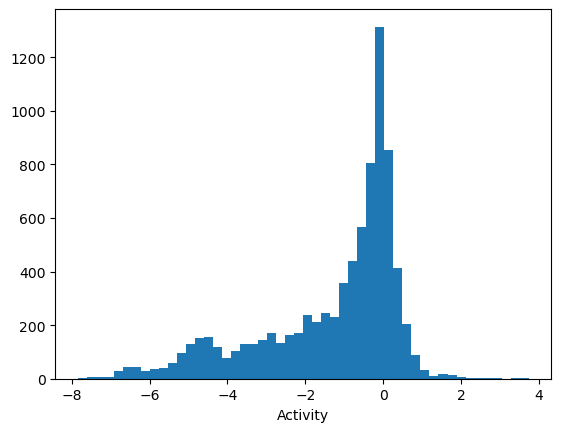

In [19]:
plt.hist(df_Kan_input['activity'],bins=50)
plt.xlabel('Activity')

# Step 3. Scatter plots and other plots

In [5]:
df_Kan_input = pd.read_csv('TniQ_activity_full_dataframe.csv')
df_Kan_Ara = pd.read_csv('TniQ_specificity_full_dataframe.csv')

Corr -0.11262774396693837


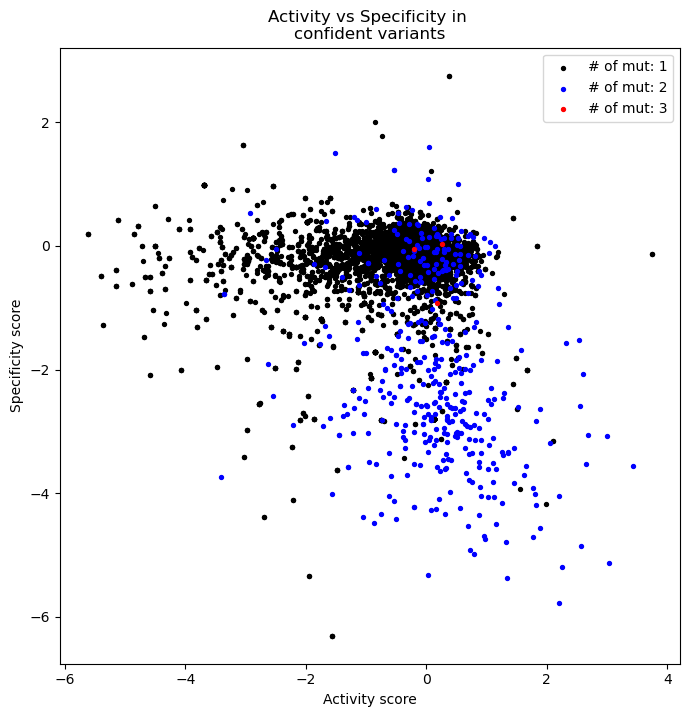

In [6]:
# Define colors for different numbers of mutations
colors = ['.', 'k', 'b', 'r']
the = 10  # Threshold for standard error
mult_variants_all = []  # List to store all multi-variant data
plt.figure(figsize=(8, 8))  # Create a new figure with specified size

# Loop over different numbers of mutations (1, 2, 3)
for n in [1, 2, 3]:
    # Filter the dataframe for rows with stderr less than the threshold and the specified number of mutations
    indx = (df_Kan_input['stderr'] < the) * (df_Kan_input['AA_mut_#'] == n)
    mult_variants = []  # List to store multi-variant data for the current number of mutations
    
    # Iterate over the filtered dataframe
    for i in df_Kan_input[indx]['AA_mut_list']:
        try:
            # Check if the corresponding row in df_Kan_Ara has stderr less than the threshold
            if df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0] < the:
                # Extract activity and specificity values and their errors
                v_act = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['activity'].values[0]
                v_spe = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['specificity'].values[0]
                err_act = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['stderr'].values[0]
                err_spe = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['stderr'].values[0]
                # Append the data to the lists
                mult_variants.append([i, v_spe, v_act])
                mult_variants_all.append([i, v_spe, v_act, err_spe, err_act, n])
        except:
            pass
    # Convert the list to a numpy array and plot the data
    mult_variants = np.array(mult_variants, dtype=object)
    plt.scatter(mult_variants[:, 2].astype(float), mult_variants[:, 1].astype(float), s=8, c=colors[n], label='# of mut: ' + str(n))

# Set plot labels and title
plt.ylabel('Specificity score')
plt.xlabel('Activity score')
plt.title('Activity vs Specificity in \nconfident variants')
plt.legend()
# Save the plot as SVG and PNG
plt.savefig('./Figures/act_vs_spec_' + str(the) + 'error.svg')
plt.savefig('./Figures/act_vs_spec_' + str(the) + 'error.png')

# Convert the list of all multi-variant data to a numpy array
mult_variants_all = np.array(mult_variants_all, dtype=object)
# Create a temporary dataframe to store the data
tmp_df = pd.DataFrame()
tmp_df['AA_mut_list'] = mult_variants_all[:, 0]
tmp_df['specificity'] = mult_variants_all[:, 1]
tmp_df['activity'] = mult_variants_all[:, 2]
tmp_df['stderr_spec'] = mult_variants_all[:, 3]
tmp_df['stderr_act'] = mult_variants_all[:, 4]
tmp_df['n_mut'] = mult_variants_all[:, 5]

# Plot the data using Plotly for interactive visualization
fig = px.scatter(tmp_df, x='activity', y='specificity', color='n_mut', color_discrete_sequence=['black', 'blue', 'red'], hover_data=['AA_mut_list', 'stderr_spec', 'stderr_act'])
fig.update_layout(
    title='Activity vs Specificity',
    xaxis_title='Activity',
    yaxis_title='Specificity',
    width=800, height=800,
)
fig.show()
# Save the interactive plot as HTML
fig.write_html('Figures/act_vs_spec_' + str(the) + 'error.html')

# Print the correlation coefficient between specificity and activity
print('Corr', np.corrcoef(mult_variants_all[:, 1].astype(float), mult_variants_all[:, 2].astype(float))[0, 1])

Text(0, 0.5, 'Occurance in double mutants')

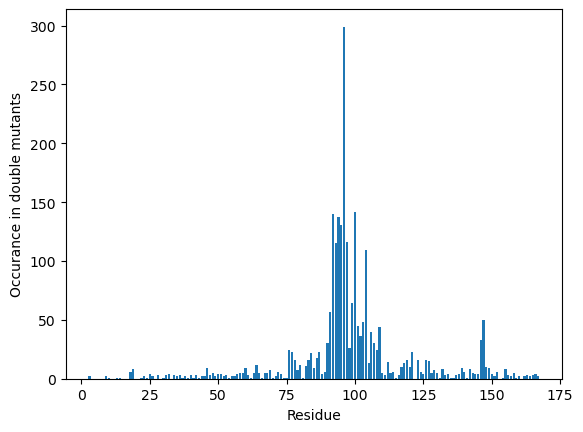

In [7]:
vals=[]
tmp=df_Kan_input[(df_Kan_input['stderr_R1']<1)*(df_Kan_input['stderr_R2']<1)*(df_Kan_input['AA_mut_#']==2)].drop_duplicates(subset='AA_mut_list')
for i in tmp['AA_mut_list'].values:
    if i!='WT':
        for l in i.split('+'):
            vals.append(int(l[1:-1]))
u,c=np.unique(vals,return_counts=True)
plt.bar(u,c)
plt.xlabel('Residue')
plt.ylabel('Occurance in double mutants')

In [8]:
print('Number of variants with act and spe errors <1:',len(tmp_df.drop_duplicates(subset='AA_mut_list')))

Number of variants with act and spe errors <1: 3079


Corr 0.8462515916018273


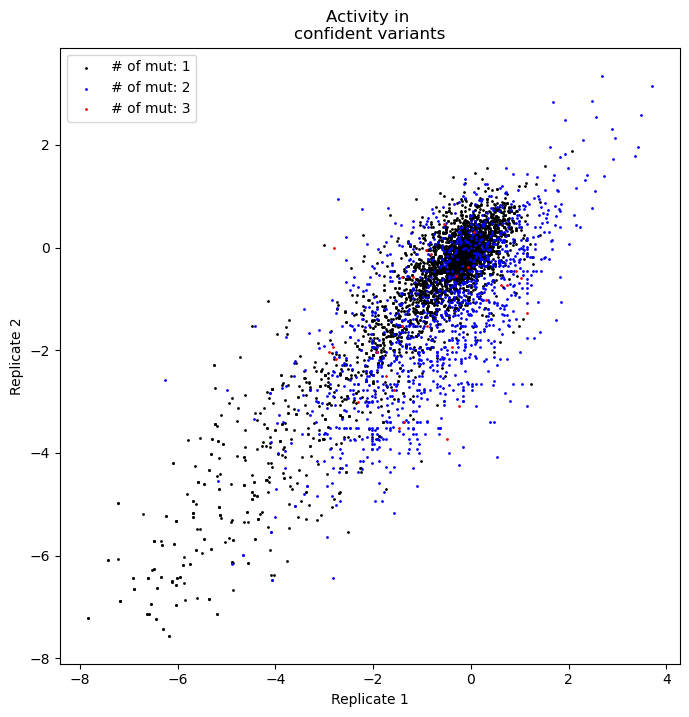

In [9]:
# Define colors for different numbers of mutations
colors = ['.', 'k', 'b', 'r']
the = 1  # Threshold for standard error
mult_variants_all = []  # List to store all multi-variant data
plt.figure(figsize=(8, 8))  # Create a new figure with specified size

# Loop over different numbers of mutations (1, 2, 3)
for n in [1, 2, 3]:
    # Filter the dataframe for rows with stderr less than the threshold for both replicates and the specified number of mutations
    indx = (df_Kan_input['stderr_R1'] < the) * (df_Kan_input['stderr_R2'] < the) * (df_Kan_input['AA_mut_#'] == n)
    mult_variants = []  # List to store multi-variant data for the current number of mutations
    
    # Iterate over the filtered dataframe
    for i in df_Kan_input[indx]['AA_mut_list']:
        # Extract activity values and their errors for both replicates
        v_r1 = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['activity_R1'].values[0]
        v_r2 = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['activity_R2'].values[0]
        e_r1 = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['stderr_R1'].values[0]
        e_r2 = df_Kan_input[df_Kan_input['AA_mut_list'] == i]['stderr_R2'].values[0]
        # Append the data to the lists
        mult_variants.append([v_r1, v_r2])
        mult_variants_all.append([i, v_r1, v_r2, e_r1, e_r2, n])
    
    # Convert the list to a numpy array and plot the data
    mult_variants = np.array(mult_variants, dtype=object)
    plt.scatter(mult_variants[:, 0].astype(float), mult_variants[:, 1].astype(float), s=1, c=colors[n], label='# of mut: ' + str(n))

# Convert the list of all multi-variant data to a numpy array
mult_variants_all = np.array(mult_variants_all, dtype=object)
# Set plot labels and title
plt.ylabel('Replicate 2')
plt.xlabel('Replicate 1')
plt.title('Activity in \nconfident variants')
plt.legend()
# Save the plot as SVG and PNG
plt.savefig('./Figures/act_rep_' + str(the) + 'error.svg')
plt.savefig('./Figures/act_rep_' + str(the) + 'error.png')

# Create a temporary dataframe to store the data
tmp_df = pd.DataFrame()
tmp_df['AA_mut_list'] = mult_variants_all[:, 0]
tmp_df['activity_R1'] = mult_variants_all[:, 1]
tmp_df['activity_R2'] = mult_variants_all[:, 2]
tmp_df['stderr_R1'] = mult_variants_all[:, 3]
tmp_df['stderr_R2'] = mult_variants_all[:, 4]
tmp_df['n_mut'] = mult_variants_all[:, 5]

# Plot the data using Plotly for interactive visualization
fig = px.scatter(tmp_df, x='activity_R1', y='activity_R2', color='n_mut', color_discrete_sequence=['black', 'blue', 'red'], hover_data=['AA_mut_list', 'stderr_R1', 'stderr_R2'])
fig.update_layout(
    title='Activity',
    xaxis_title='Replicate 1',
    yaxis_title='Replicate 2',
    width=800, height=800,
)
fig.show()
# Save the interactive plot as HTML
fig.write_html('Figures/act_rep_' + str(the) + 'error.html')

# Print the correlation coefficient between activity values of replicate 1 and replicate 2
print('Corr', np.corrcoef(mult_variants_all[:, 1].astype(float), mult_variants_all[:, 2].astype(float))[0, 1])

In [10]:
print('Number of variants with act <1:',len(tmp_df.drop_duplicates(subset='AA_mut_list')))

Number of variants with act <1: 3917


Corr 0.9068614707428264


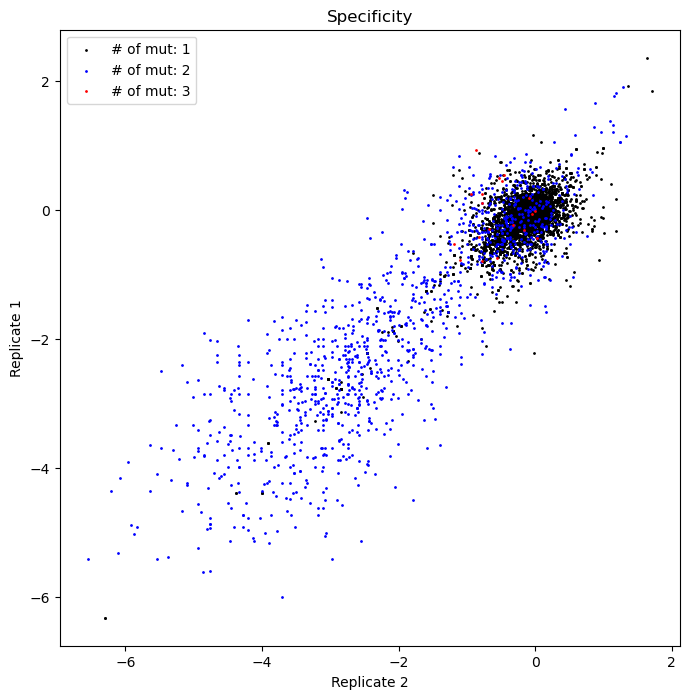

In [11]:
# Define a list of colors to be used for plotting
colors=['.', 'k', 'b', 'r']
# Set a threshold value for filtering
the = 1
# Create an empty list to store all mutation variants data
mult_variants_all = []
# Initialize a figure for plotting with specified size
plt.figure(figsize=(8,8))
# Loop over the number of mutations (1, 2, 3)
for n in [1, 2, 3]:
    # Create an index to filter the dataframe based on the threshold and number of mutations
    indx = (df_Kan_Ara['stderr_R1'] < the) & (df_Kan_Ara['stderr_R2'] < the) & (df_Kan_Ara['AA_mut_#'] == n)
    # Create an empty list to store mutation variants for the current number of mutations
    mult_variants = []
    # Loop over the filtered dataframe to collect specificity and standard error values
    for i in df_Kan_Ara[indx]['AA_mut_list']:
        v_r1 = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['specificity_R1'].values[0]
        v_r2 = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['specificity_R2'].values[0]
        e_r1 = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['stderr_R1'].values[0]
        e_r2 = df_Kan_Ara[df_Kan_Ara['AA_mut_list'] == i]['stderr_R2'].values[0]
        # Append the collected values to the list for the current number of mutations
        mult_variants.append([v_r1, v_r2])
        # Append the collected values to the list for all mutation variants
        mult_variants_all.append([i, v_r1, v_r2, e_r1, e_r2, n])
    # Convert the list to a numpy array
    mult_variants = np.array(mult_variants, dtype=object)
    # Scatter plot the specificity values for the current number of mutations
    plt.scatter(mult_variants[:, 0].astype(float), mult_variants[:, 1].astype(float), s=1, c=colors[n], label='# of mut: ' + str(n))

# Convert the list of all mutation variants to a numpy array
mult_variants_all = np.array(mult_variants_all, dtype=object)
# Set labels and title for the plot
plt.ylabel('Replicate 1')
plt.xlabel('Replicate 2')
plt.title('Specificity')
# Add a legend to the plot
plt.legend()
# Save the plot as SVG and PNG files
plt.savefig('./Figures/spe_rep_' + str(the) + 'error.svg')
plt.savefig('./Figures/spe_rep_' + str(the) + 'error.png')
# Create a temporary dataframe to store the mutation variants data
tmp_df = pd.DataFrame()
tmp_df['AA_mut_list'] = mult_variants_all[:, 0]
tmp_df['specificity_R1'] = mult_variants_all[:, 1]
tmp_df['specificity_R2'] = mult_variants_all[:, 2]
tmp_df['stderr_R1'] = mult_variants_all[:, 3]
tmp_df['stderr_R2'] = mult_variants_all[:, 4]
tmp_df['n_mut'] = mult_variants_all[:, 5]
# Plot the specificity values using Plotly
fig = px.scatter(tmp_df, x='specificity_R1', y='specificity_R2', color='n_mut', color_discrete_sequence=['black', 'blue', 'red'], hover_data=['AA_mut_list', 'stderr_R1', 'stderr_R2'])
fig.update_layout(
    title='Specificity',
    xaxis_title='Replicate 1',
    yaxis_title='Replicate 2',
    width=800, height=800,
)
# Show the Plotly plot
fig.show()
# Save the Plotly plot as an HTML file
fig.write_html('Figures/spec_rep_' + str(the) + 'error.html')
# Print the correlation coefficient between the specificity values of the two replicates
print('Corr', np.corrcoef(mult_variants_all[:, 1].astype(float), mult_variants_all[:, 2].astype(float))[0, 1])

In [12]:
print('Number of variants with act <1:',len(tmp_df.drop_duplicates(subset='AA_mut_list')))

Number of variants with act <1: 3644


In [13]:
def mut_in_context(df,suffixes,mutation,style):
    """
    Plots the enrichment score of a specific mutation in the context of wild-type synonymous mutations.

    Parameters:
    df (DataFrame): DataFrame containing mutation and sequence data.
    suffixes (tuple): Suffixes to apply to overlapping column names in the resulting DataFrame.
    mutation (str): The specific mutation to highlight in the plot.
    style (str): The style of the plot, specifying which column to use for the x-axis.
    """
    mut=mutation
    fig=plt.figure(figsize=(3,2.5))
    ax=fig.add_subplot(111)
    ax.set_title(mut+' '+style+' in\ncontext of WT syn mut')
    kernel = stats.gaussian_kde(df[df['AA_mut_list']=='WT']['enrich'+suffixes[1]])

    sub_df=df[df['AA_mut_list']==mut]
    ax.errorbar(sub_df[style].values[0],[0.15],xerr=sub_df['stderr'].values[0],capsize=5,color='k')
    ax.errorbar(sub_df[style].values[0],[0.15],yerr=0.005,capsize=0,color='k')
    ax.scatter(sub_df['enrich'+suffixes[0]],np.zeros(len(sub_df))+0.15,c='k',s=5)
    ax.scatter(sub_df['enrich'+suffixes[1]],np.zeros(len(sub_df))+0.15,c='k',s=5)
    scatter=ax.plot(sub_df[style].values[0],[0.15],markeredgecolor='k',markerfacecolor="None")
    x=np.linspace(-5,5,50)
    ax.plot(x,kernel(x)/8,color='k')
    ax.fill_between(x,kernel(x)/8,edgecolor='gray',facecolor='gray')

    ax.set_xlabel('Score')
    ax.set_yticks([])
    ax.set_ylim([-0.05,0.2])
    return fig

In [14]:
for row in np.unique(df_Kan_Ara[df_Kan_Ara['AA_mut_#']<5]['AA_mut_list'].values):
    fig = mut_in_context(df_Kan_Ara,['_Ara_R1','_Ara_R2'],row,'specificity')
    plt.tight_layout()
    fig.savefig('./Figures/specificity/'+row+'.png',dpi=300)
    del fig
    plt.close()
    break

In [15]:
for row in np.unique(df_Kan_input[df_Kan_input['AA_mut_#']<5]['AA_mut_list'].values):
    fig = mut_in_context(df_Kan_input,['_Kan_R1','_Kan_R2'],row,'activity')
    plt.tight_layout()
    fig.savefig('./Figures/activity/'+row+'.png',dpi=300)
    del fig
    plt.close()
    break

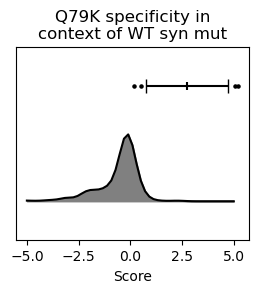

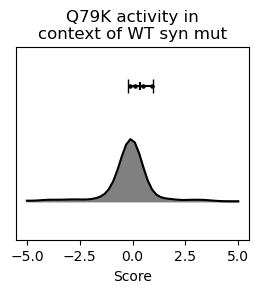

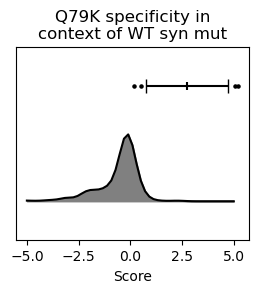

In [20]:
mut='Q79K'
mut_in_context(df_Kan_input,['_Kan_R1','_Kan_R2'],mut,'activity')
mut_in_context(df_Kan_Ara,['_Ara_R1','_Ara_R2'],mut,'specificity')

In [21]:
def min_mean_max_vals(df,type):
    m_vals=[[] for i in range(166)]
    for index, row in df.iterrows():
        try: 
            m_vals[int(row['AA_mut_list'][1:-1])-2].append(row[type])
        except:pass
    mean_val=np.array([np.mean(i) for i in m_vals])
    max_val=np.array([np.max(i) for i in m_vals])
    min_val=np.array([np.min(i) for i in m_vals])
    plt.figure(figsize=(15,2))
    plt.plot(list(range(2,168)),mean_val,color='k')
    plt.plot(list(range(2,168)),max_val,color='r')
    plt.plot(list(range(2,168)),min_val,color='b')
    plt.fill_between(list(range(2,168)),y1=max_val,y2=min_val,color='b',alpha=0.2)
    plt.xlim([2,167])
    plt.axhline(0,color='k',linestyle='--')

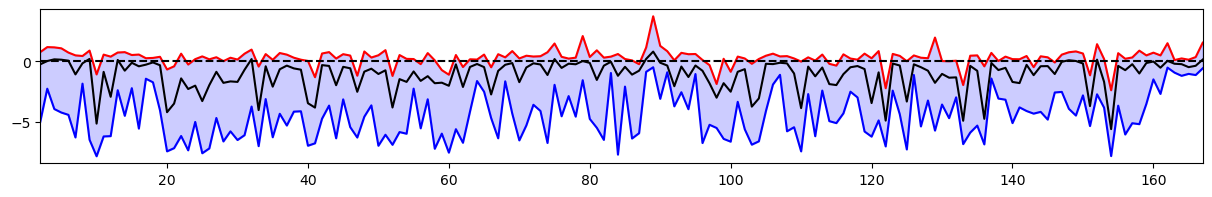

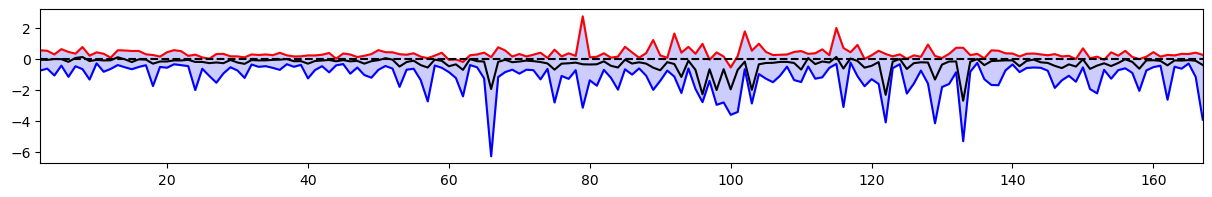

In [23]:
min_mean_max_vals(df_Kan_input,'activity')
min_mean_max_vals(df_Kan_Ara,'specificity')

# Step 4. Heat map

In [24]:
def plot_enrichemnt_matrix(type,df_Ara_Kan_input_sm,AA_refSeq,error,minv,maxv,size,WT_value):
    # Define the range of positions
    start_position = 2
    end_position = 167

    single_letter_amino_acids = np.array(['*', 'C', 'P', 'G', #special
                                'I', 'V', 'L', 'F', 'M', 'A', 'W', #nonpolar
                                'Y', 'T', 'S', 'N', 'Q', #polar
                                'E', 'D', #negative
                                'H', 'K', 'R']) #positive

    #Mat mutations into matrix with enrichment values
    comparison_matrix=np.ones((len(single_letter_amino_acids),166))*np.nan
    stderrs=np.zeros((len(single_letter_amino_acids),166))*np.nan
    for i in df_Ara_Kan_input_sm.index:
        pos=df_Ara_Kan_input_sm['position'][i]
        mut=df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa=mut[-1]
        hm_pos=np.where(single_letter_amino_acids==taa)[0][0]
        comparison_matrix[hm_pos,pos-2]=df_Ara_Kan_input_sm[type][i]
        stderrs[hm_pos,pos-2]=df_Ara_Kan_input_sm['stderr'][i]
    #Create markers for WT and no data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        taa=AA_refSeq[i]
        markers[np.where(single_letter_amino_acids==taa)[0][0],i] = '●'
        comparison_matrix[np.where(single_letter_amino_acids==taa)[0][0],i]=WT_value
    #Define markers for WT and No data
    markers = np.full(comparison_matrix.shape, '', dtype=object)
    markers[comparison_matrix == WT_value] = '●'
    comparison_matrix=comparison_matrix
    customdata = []
    #Label hover data
    for i in range(len(single_letter_amino_acids)):
        row = []
        for j in range(start_position, end_position + 1):
            row.append(f"Position: {j}<br>Amino Acid: {single_letter_amino_acids[i]}<br>Enrichment Score: {comparison_matrix[i, j - start_position]}<br>StdErr: {stderrs[i, j - start_position]}")
        customdata.append(row)
    
    #Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=comparison_matrix,
        x=list(range(start_position, end_position + 1)),
        y=single_letter_amino_acids,
        colorscale='RdBu_r',
        customdata=customdata,
        text=markers,
        hovertemplate='%{customdata}<extra></extra>',
        colorbar=dict(title='Score',titlefont=dict(size=18), tickfont=dict(size=18)),
        texttemplate='%{text}',
        textfont=dict(color='black', size=10),
        xgap=0.5, ygap=0.5,
        zmin=minv,zmax=maxv,
    ))
    if error==True:
        num_rows, num_cols = comparison_matrix.shape
        
        for i in range(num_rows):
            for j in range(num_cols):
                value = stderrs[i, j]
                if float(value) > 1:
                    # Scale the length of the diagonal line based on the cell value
                    length = value/np.max(stderrs[~np.isnan(stderrs)])  # You can adjust this scaling factor as needed
                    fig.add_shape(
                        type="line",
                        x0=j+2-length/2, y0=i-length/2,x1=j+2+length/2, y1=i+length/2,
                        line=dict(color="gray", width=2)
                    )

    # Update layout to remove grid and adjust layout
    fig.update_layout(
        title=type+' TniQ',
        xaxis_title='Position',
        yaxis_title='Amino Acid',
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(tickfont=dict(size=18),showticklabels=True,ticks='outside'),
        xaxis=dict(dtick=10,tickangle=300,tickfont=dict(size=16),showticklabels=True,ticks='outside'),
        width=size[0], height=size[1],
    )

    fig.show()
    return fig, comparison_matrix, stderrs

In [25]:
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import ListedColormap
from matplotlib.colors import TwoSlopeNorm
def asymmetric_seaborn_matrix(data_type, df_Ara_Kan_input_sm, AA_refSeq, minv, maxv, error_threshold):
    start_position = 2
    end_position = 167

    single_letter_amino_acids = np.array(['R', 'K', 'H', 'D', 'E',
                                'Q', 'N', 'S', 'T', 'Y', 'W', 'A',
                                'M', 'F', 'L', 'V', 'I',
                                'G', 'P',
                                'C', '*'])

    comparison_matrix = np.full((len(single_letter_amino_acids), end_position-1), np.nan)
    stderrs = np.full((len(single_letter_amino_acids), end_position-1), np.nan)

    for i in df_Ara_Kan_input_sm.index:
        pos = df_Ara_Kan_input_sm['position'][i]
        mut = df_Ara_Kan_input_sm['AA_mut_list'][i]
        taa = mut[-1]
        hm_pos = np.where(single_letter_amino_acids == taa)[0][0]
        stderrs[hm_pos, pos - 2] = df_Ara_Kan_input_sm['stderr'][i]
        if df_Ara_Kan_input_sm['stderr'][i]<error_threshold:
            comparison_matrix[hm_pos, pos - 2] = df_Ara_Kan_input_sm[data_type][i]
        

    markers = np.full(comparison_matrix.shape, '', dtype=object)
    for i in range(len(AA_refSeq)):
        taa = AA_refSeq[i]
        aa_index = np.where(single_letter_amino_acids == taa)[0][0]
        markers[aa_index, i] = '●'
        comparison_matrix[aa_index, i] = 0
    print('# of positive values:',np.sum(comparison_matrix>=0.01))

    x_labels = list(range(start_position, end_position + 1))
    y_labels = single_letter_amino_acids
    cmap = sns.color_palette("RdBu_r", as_cmap=True)
    cmap.set_bad(color='grey')

    norm = mcolors.TwoSlopeNorm(vmin=minv, vcenter=0, vmax=maxv)
    
    fig = plt.figure(figsize=(50, 30))
    sns.heatmap(
    comparison_matrix,
    cmap=cmap,
    norm=norm,
    xticklabels=x_labels,
    yticklabels=y_labels,
    annot=False,
    fmt=".2f",
    square=True,
    linewidths=0.4,
    linecolor='black',
    cbar_kws={'label': 'Score', 'shrink': 0.5})

    plt.yticks(rotation=0, fontsize=17,fontname='Arial')
    plt.xticks(
        ticks=[i - start_position + 0.5 for i in range(10, end_position + 1, 10)],
        labels=range(10, end_position + 1, 10),
        fontsize=40, fontname='Arial'
    )
    num_rows, num_cols = comparison_matrix.shape
    for i in range(num_rows):
        for j in range(num_cols):
            if comparison_matrix[i, j] == 0:
                plt.plot(j + 0.5, i + 0.5, 'k.', markersize=10)

    plt.tight_layout()
    plt.show()

    return fig, comparison_matrix, stderrs

/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_51314/638351296.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_51314/638351296.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of positive values: 762


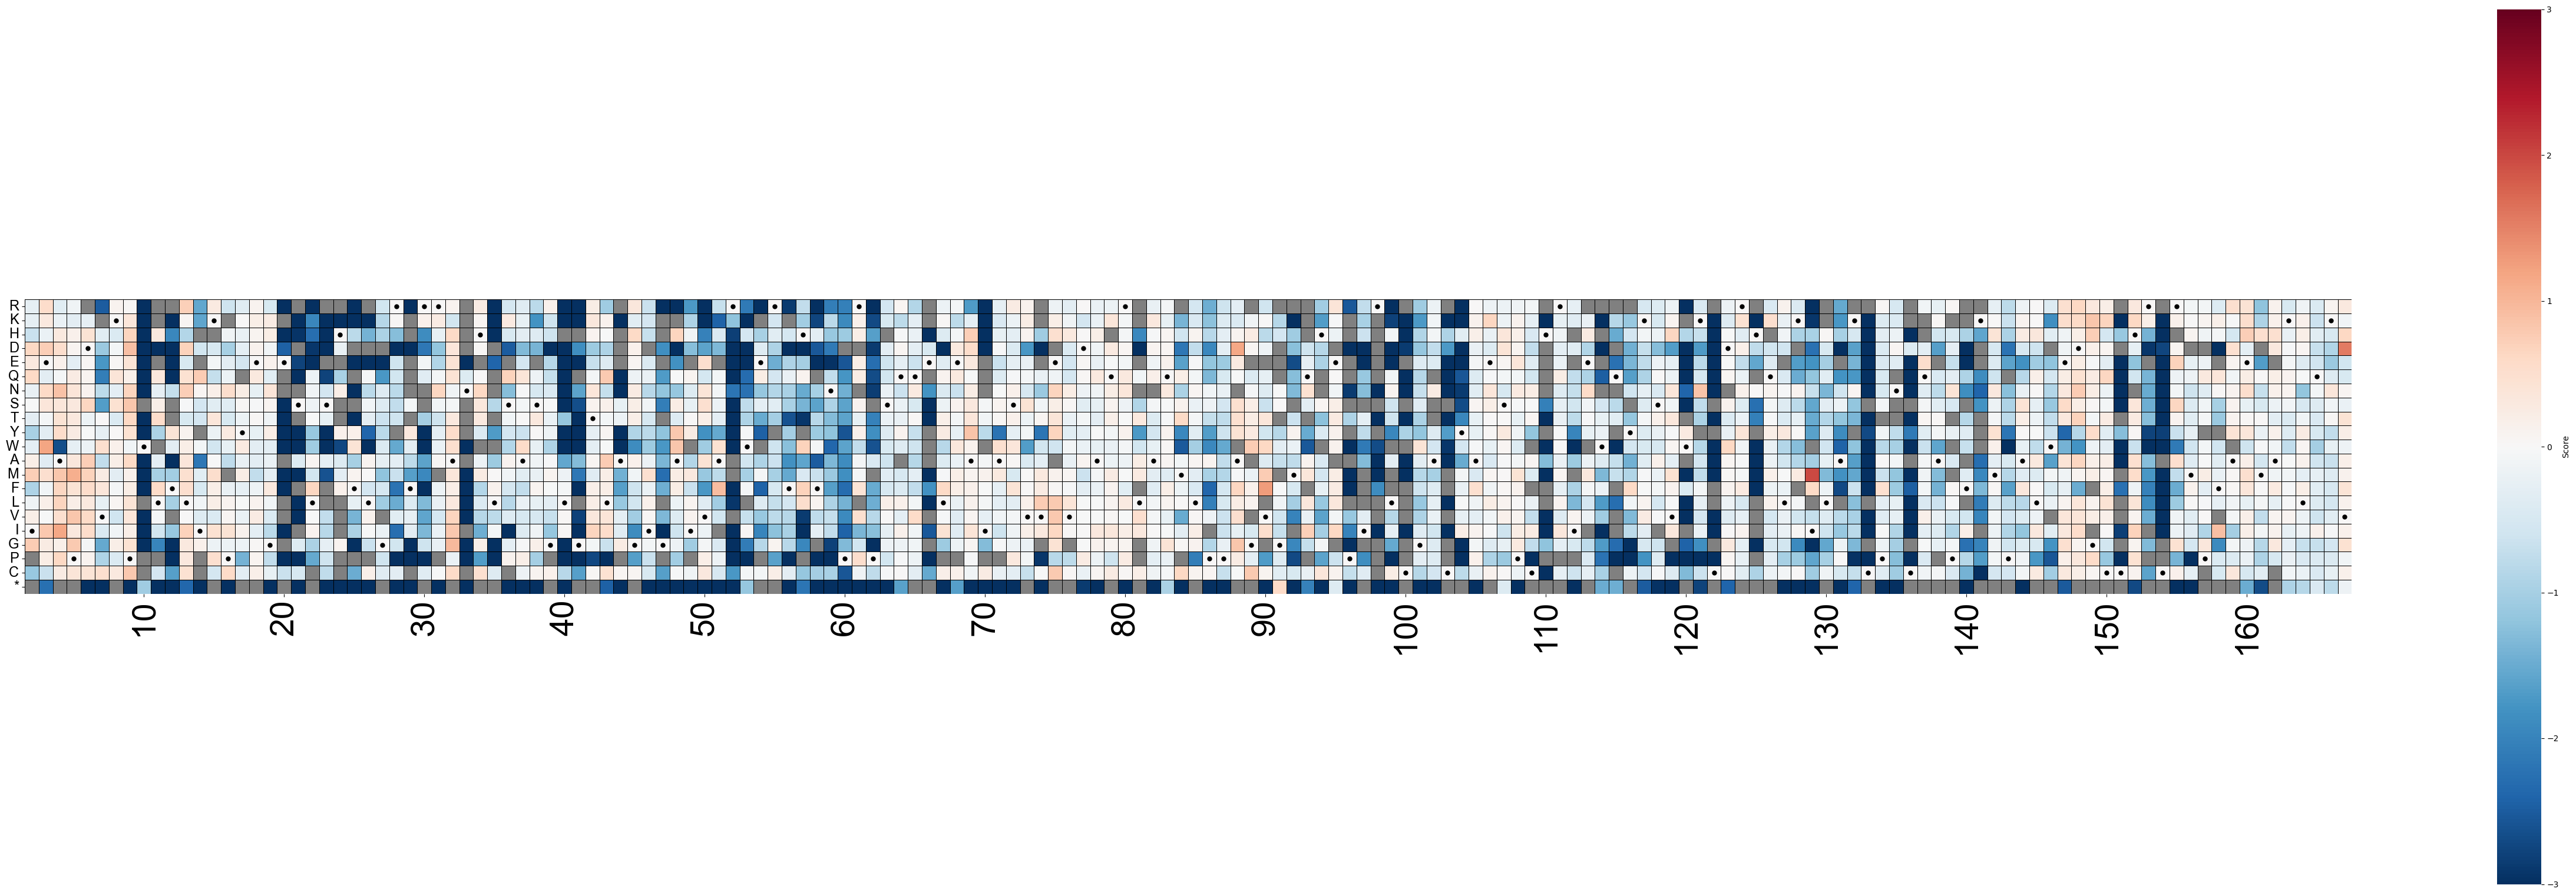

In [26]:
df_Kan_input_sm=df_Kan_input[df_Kan_input['AA_mut_#']==1]
df_Kan_input_sm['position']=[int(''.join(list(i[1:-1]))) for i in df_Kan_input_sm['AA_mut_list']]
df_Kan_input_sm.replace(-np.inf,-10,inplace=True)
data_type='activity' # Could be Ara or Kan
fig, activity, stderr_act = asymmetric_seaborn_matrix(data_type, df_Kan_input_sm, AA_refSeq, -3, 3, 1)
fig.savefig('./Figures/TniQ_' + data_type + '.svg', format='svg')


/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_51314/2861830817.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4s/khfsl_493zbgmw8n9l9b1ysm0000gp/T/ipykernel_51314/2861830817.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of positive values: 759


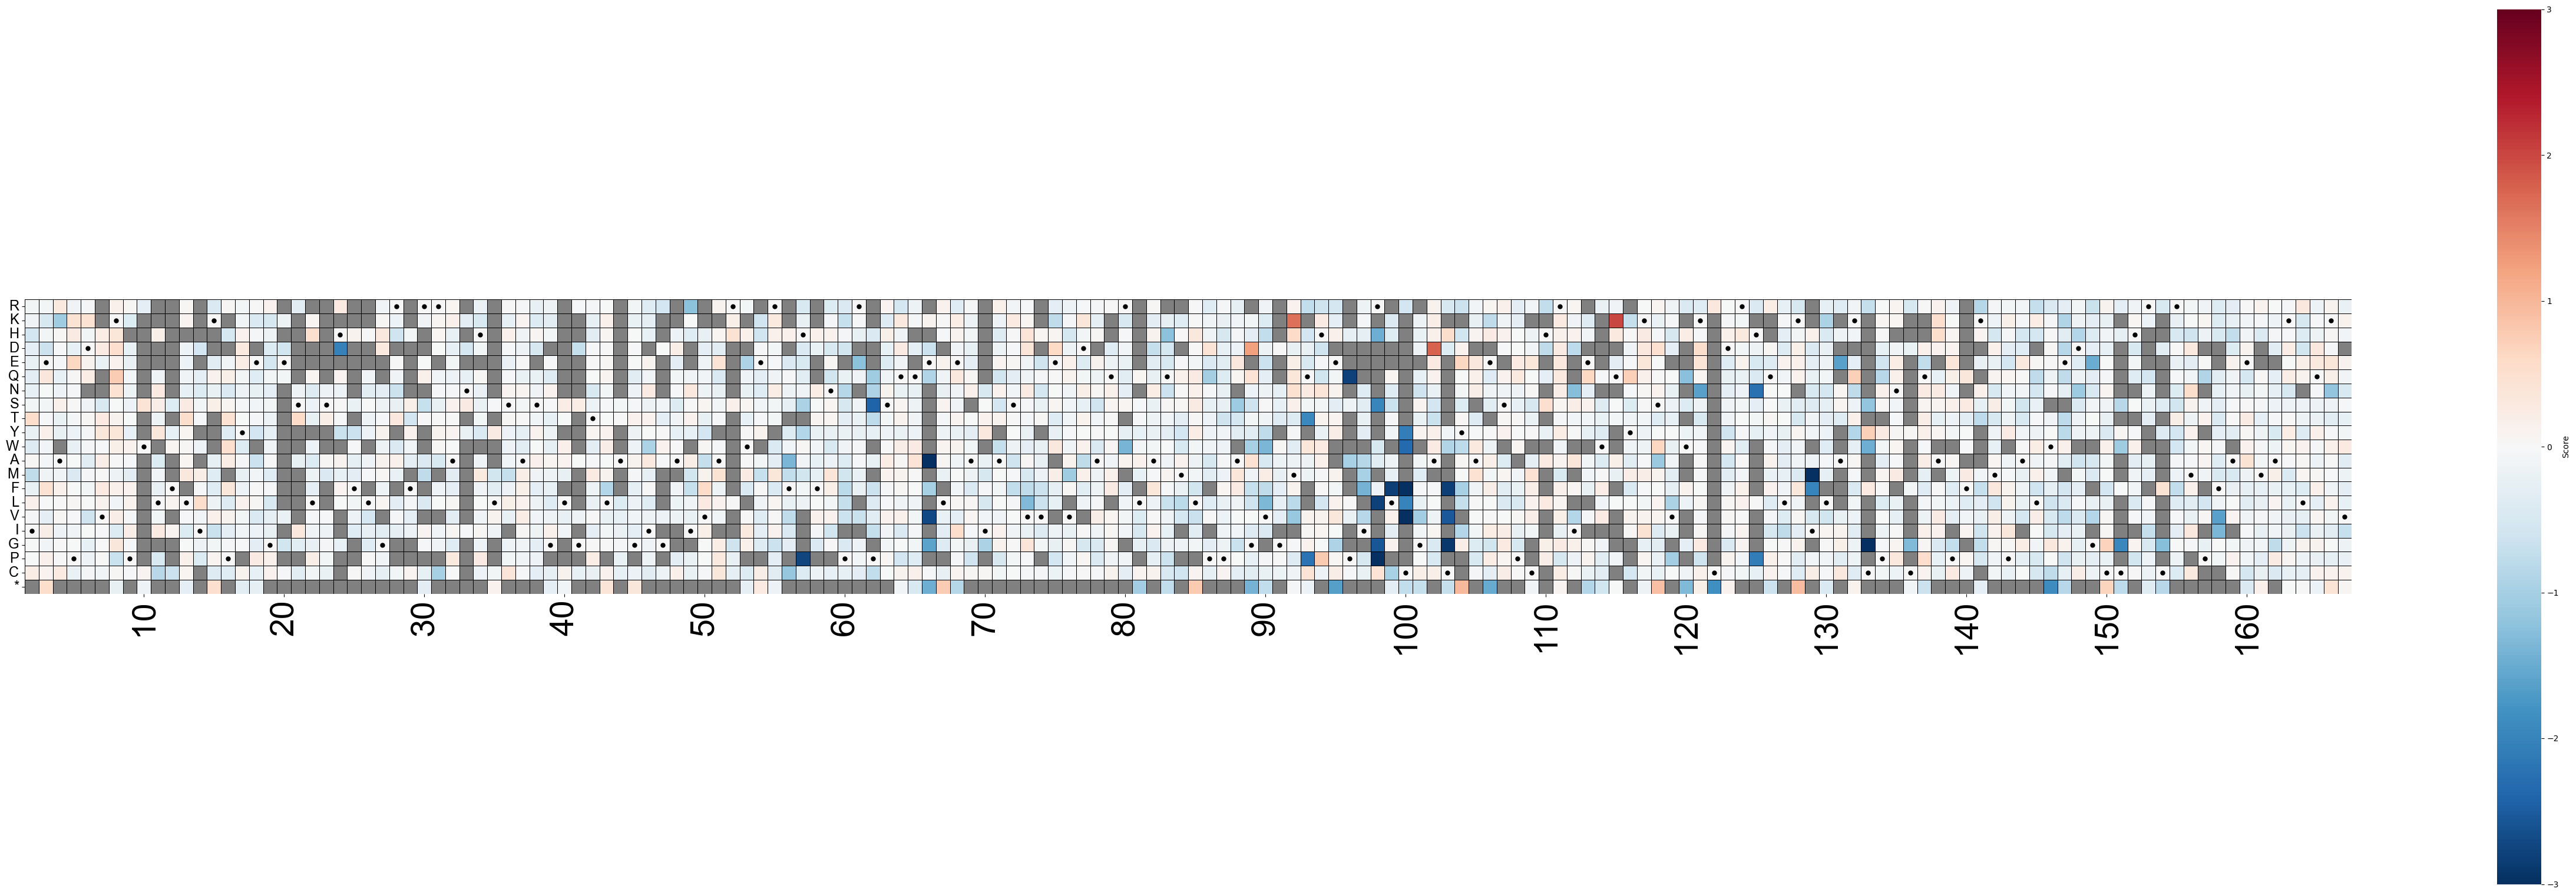

In [27]:
df_Kan_Ara_sm=df_Kan_Ara[df_Kan_Ara['AA_mut_#']==1]
df_Kan_Ara_sm['position']=[int(''.join(list(i[1:-1]))) for i in df_Kan_Ara_sm['AA_mut_list']]
df_Kan_Ara_sm.replace(-np.inf,-10,inplace=True)
data_type='specificity' # Could be Ara or Kan
fig, activity, stderr_act = asymmetric_seaborn_matrix(data_type, df_Kan_Ara_sm, AA_refSeq, -3, 3, 1)
fig.savefig('./Figures/TniQ_' + data_type + '.svg', format='svg')

# Step 5. Frustration 

In [30]:
import frustratometer
import matplotlib.pylab as plt
import numpy as np
import mdtraj as md
from scipy.stats import mannwhitneyu

In [31]:
# Define the path to your PDB file
pdb_path = '../8rdu/8rdu_TniQ(CDE).pdb'
offset_TNIQ=3
AA=list('-ACDEFGHIKLMNPQRSTVWY')
structure = frustratometer.Structure.full_pdb(pdb_path)
print(len(structure.sequence),structure.sequence)
## Single residue frustration with electrostatics
AWSEM_model = frustratometer.AWSEM(structure,distance_cutoff_contact=9.5) 
native_frust=AWSEM_model.frustration(kind='singleresidue')

@> 5438 atoms and 1 coordinate set(s) were parsed in 0.04s.
/Users/edoderor/anaconda3/envs/pbase/lib/python3.10/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning:

Ignoring unrecognized record 'END' at line 5443

@> 5438 atoms and 1 coordinate set(s) were parsed in 0.03s.


678 EAPDVKPWLFLIKPYEGESLSHFLGRFRRANHLSASGLGTLAGIGAIVARWERFHFNPRPSQQELEAIASVVEVDAQRLAQMLPPAGVGMQHEPIRLCGACYAESPCHRIEWQYKSVWKCDRHQLKILAKCPNCQAPFKMPALWEDGCCHRCRMPFAEMAKLQKEWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEYEWLQAEIARLKGKSIVPLQQVKTLHDWLDGKRKARKSCRVVGESRTGKTVACDAYRYRHKPQQEAGRPPTVPVVYIRPHQKCGPKDLFKKITEYLKYRVTKGTVSDFRDRTIEVLKGCGVEMLIIDEADRLKPETFADVRDIAEDLGIAVVLVGTDRLDAVIKRDEQVLERFRAHLRFGKLSGEDFKNTVEMWEQMVLKLPVSSNLKSKEMLRILTSATEGYIGRLDEILREAAIRSLSRGLKKIDKAVLQEVAKEY


In [32]:
df_tmp=df_Kan_input.drop_duplicates(subset=['AA_mut_list'])
indx=(df_tmp['stderr']<1)*(df_tmp['AA_mut_#']>0)*(df_tmp['AA_mut_#']<5)
mult_variants=[]
for i in df_tmp[indx]['AA_mut_list']:
    try:
        v_act=df_tmp[df_tmp['AA_mut_list']==i]['activity'].values[0]
        mult_variants.append([i,v_act])
    except:
        pass
mult_variants=np.array(mult_variants,dtype=object)

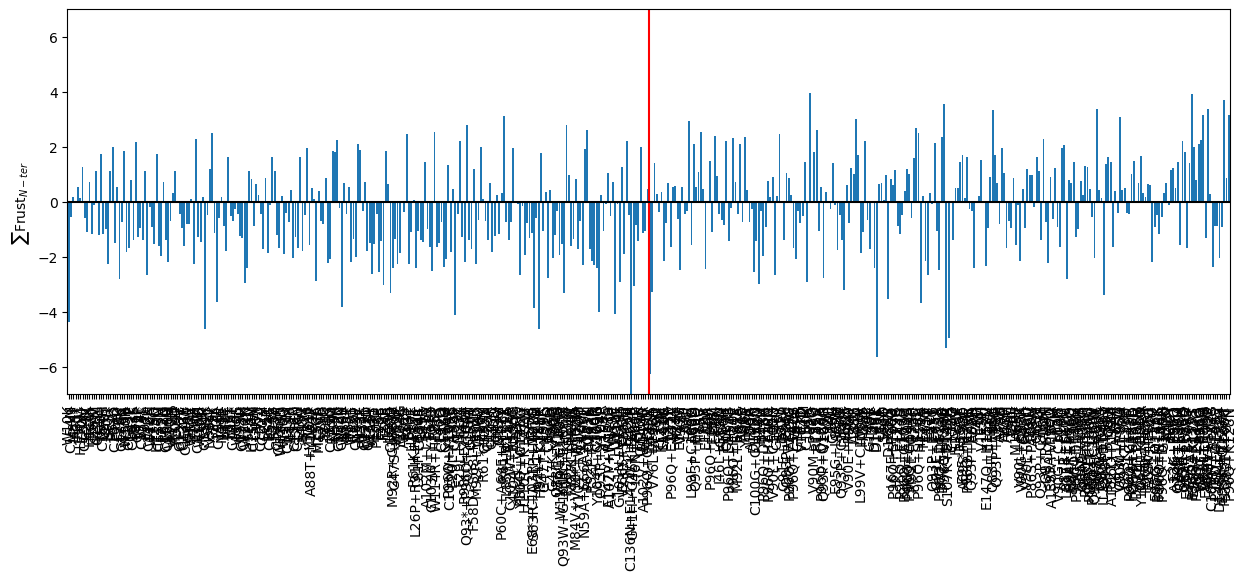

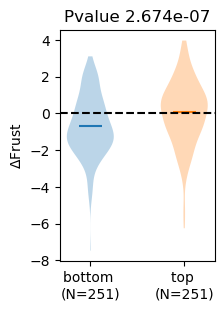

In [36]:
top_p=mult_variants[mult_variants[:,1]>0.5,0]
N=len(top_p)
bottom_p=[i[0] for i in mult_variants[np.argsort(mult_variants[:,1])][:N]]

mut_list_b=bottom_p
diff_frust_b=[]
for mutation in mut_list_b:
    native_sequence=structure.sequence
    tniq_cap=len(native_sequence)-offset_TNIQ
    ind_mut=mutation.split('+')
    newseq=native_sequence
    for mut in ind_mut:
        gm = list(mut)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        if gm[1]>=offset_TNIQ and gm[1]<tniq_cap:
            mut_position=gm[1]-offset_TNIQ
            mut_aa=gm[2]
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
    frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
    diff_frust_b.append(np.sum(frustration_values-native_frust))

mut_list_g=top_p
diff_frust_g=[]
for mutation in mut_list_g:
    native_sequence=structure.sequence
    tniq_cap=len(native_sequence)-offset_TNIQ
    ind_mut=mutation.split('+')
    newseq=native_sequence
    for mut in ind_mut:
        gm = list(mut)
        gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
        if gm[1]>=offset_TNIQ and gm[1]<tniq_cap:
            mut_position=gm[1]-offset_TNIQ
            mut_aa=gm[2]
            newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
    frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')
    diff_frust_g.append(np.sum(frustration_values-native_frust))

mut_list=np.concatenate([mut_list_b,mut_list_g])
diff_frust=np.concatenate([diff_frust_b,diff_frust_g])
plt.figure(figsize=(15,5))
plt.bar(mut_list,diff_frust)
plt.xticks(rotation=90)
plt.axvline(len(mut_list_b)-0.5,color='red')
plt.axhline(0,color='k')
plt.ylabel(r'$\sum \text{Frust}_{N-ter}$')
plt.xlim([-0.5,len(mut_list)-0.5])
plt.ylim([-7,7])
plt.savefig('Figures/top_bot_frust_mut.svg')
plt.savefig('Figures/top_bot_frust_mut.png')

plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:N]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[N:]],positions=[1],showmeans=True, showextrema=False)
plt.ylabel(r'$\Delta \text{Frust}$')
plt.xticks([0,1],['bottom \n(N='+str(len(mut_list_b))+')','top \n(N='+str(len(mut_list_g))+')'])
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],10)))
plt.savefig('Figures/frust_violin_plot.svg')

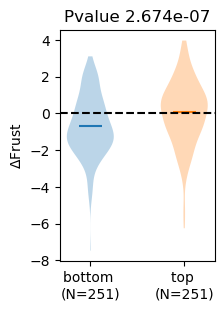

In [38]:
plt.figure(figsize=(2,3))
p=plt.violinplot([diff_frust[:N]],positions=[0],showmeans=True, showextrema=False)
p=plt.violinplot([diff_frust[N:]],positions=[1],showmeans=True, showextrema=False)
plt.ylabel(r'$\Delta \text{Frust}$')
plt.xticks([0,1],['bottom \n(N='+str(len(mut_list_b))+')','top \n(N='+str(len(mut_list_g))+')'])
plt.axhline(0,color='k',linestyle='--')
plt.title('Pvalue '+str(np.round(mannwhitneyu(diff_frust[:N],diff_frust[N:])[1],10)))
plt.savefig('Figures/frust_violin_context.svg')

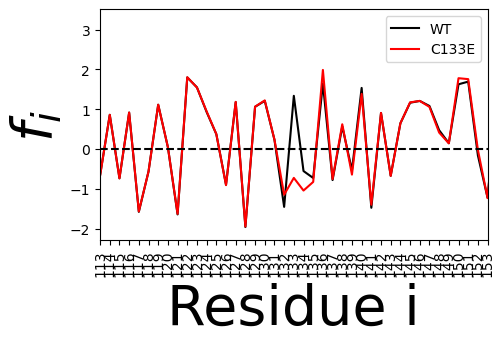

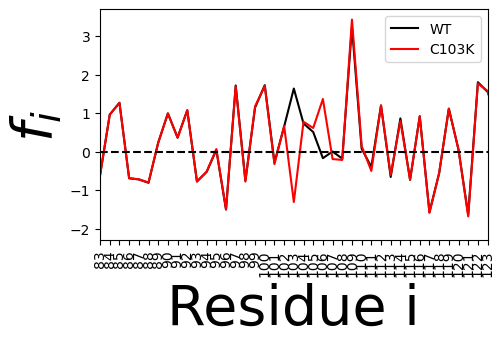

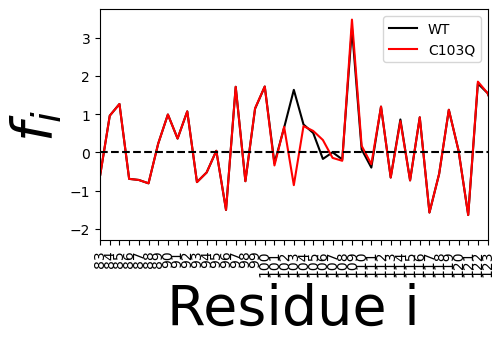

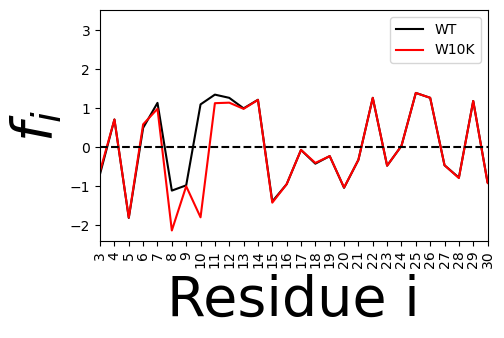

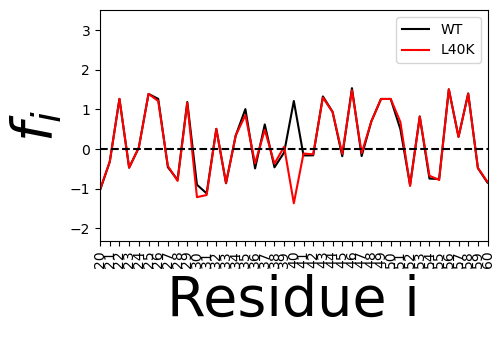

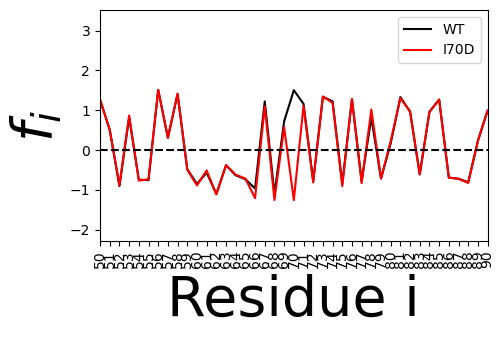

In [35]:
l= ['C133E','C103K','C103Q','W10K','L40K','I70D']
for mutation in l:
    native_sequence=structure.sequence
    tniq_cap=len(native_sequence)-offset_TNIQ
    gm = list(mutation)
    gm = [gm[0],int(''.join(gm[1:-1])),gm[-1]]
    if gm[1]>=offset_TNIQ and gm[1]<tniq_cap:
        mut_position=gm[1]-offset_TNIQ
        mut_aa=gm[2]
        newseq=native_sequence
        newseq=newseq[:mut_position]+mut_aa+newseq[mut_position+1:]
        frustration_values=AWSEM_model.frustration(sequence=newseq,kind='singleresidue')

    plt.figure(figsize=(5,3))
    plt.plot(native_frust,color='k',label='WT')
    plt.plot(frustration_values,color='r',label=mutation)
    plt.ylabel("$f_{i}$",fontsize=40); plt.xlabel("Residue i",fontsize=40)
    plt.xticks(list(range(0,len(structure.sequence))),list(range(offset_TNIQ,len(structure.sequence)+offset_TNIQ)),rotation=90)
    plt.axhline(0,linestyle='--',color='k')
    plt.xlim([np.max([0,mut_position-20]),mut_position+20])
    plt.legend()
    plt.savefig('frust_profile_'+mutation+'.svg')